In [55]:
!pip install ffmpeg-python
!pip install sounddevice

import matplotlib.pyplot as plt
from IPython.display import HTML, Audio
from base64 import b64decode
import numpy as np
import json


import struct

from scipy.io.wavfile import read as wav_read
from scipy import signal, stats
from scipy.signal import chirp, detrend

import io
import ffmpeg

import sounddevice as sd
import statistics
import matplotlib.pyplot as plt

import time
import numpy as np
from scipy.io import wavfile

from scipy.signal import detrend, butter, filtfilt, find_peaks, savgol_filter

In [57]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutoff / nyq
    b, a = signal.butter(order, normalCutoff, btype='low')
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def highpass(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='high')
    return filtfilt(b, a, data)

In [101]:
def play_and_record_chirp(freq_low,freq_high,sample_rate,chirp_duration, sd):

    sd.default.channels   = 1
    sd.default.samplerate = sample_rate

    chirp_t               = np.linspace(0, chirp_duration, int(sample_rate*chirp_duration))
    chirp_x               = chirp(chirp_t,f0=freq_low,f1=freq_high,t1=chirp_duration,method='linear').astype(np.float32)
    chirps_needed         = int(1.0 / chirp_duration)
    tx                    = np.tile(chirp_x, chirps_needed)
    rx                    = sd.playrec(tx)

    return tx,rx

In [105]:
# sample_rate = 48000
# freq_low    = 17000
# freq_high   = 23000

# chirp_length   = .1
# total_duration = 30   # extend final sound file to "total_duration" seconds

sample_rate = 48000
freq_low = 17000        # start of chirp (Hz)
freq_high = 23000       # end of chirp (Hz)
chirp_length = 0.1      # duration of each chirp in seconds
total_duration = 30     # total recording time in seconds

time = 0
tx, rx = [], []
while time < total_duration:
    time += 1
    ntx, nrx = play_and_record_chirp(freq_low,freq_high,sample_rate,chirp_length,sd)
    tx.append(ntx)
    rx.append(nrx)
    if len(tx) < 15: #window size not long enough yet
        continue
    else:
        tx_sig = np.concatenate(tx);
        rx_sig = np.concatenate(rx)[:,0]
        num_chirps_recorded = int(rx_sig.shape[0] // (chirp_length * sample_rate))
        
        # trim audio to a whole number of chirps recorded
        rx_sig = rx_sig[:int(num_chirps_recorded * chirp_length * sample_rate)]
        
        rx_data = np.array(np.split(rx_sig, num_chirps_recorded))
        tx_data = np.tile(tx_sig[0:int(chirp_length*sample_rate)], (num_chirps_recorded, 1))
        
        time_to_drop = 1
        segments_to_drop = int(time_to_drop/chirp_length)
        rx_data = rx_data[segments_to_drop:]
        tx_data = tx_data[segments_to_drop:]
        
        window_length = rx_data.shape[1]
        
        sample_index = 0
        
        ### save to json for testing ###
        rx_list = rx_data.tolist()
        tx_list = tx_data.tolist()
        
        with open("rx_hrbr.json", "w") as f:
            json.dump(rx_list, f)
        
        with open("tx_hrbr.json", "w") as f:
            json.dump(tx_list, f)
        ### save to json for testing ###

        # --- Load Data ---
        with open("tx_hrbr.json", "r") as f_tx, open("rx_hrbr.json", "r") as f_rx:
            tx_data = json.load(f_tx)
            rx_data = json.load(f_rx)
        
        tx_data = np.array(tx_data)
        rx_data = np.array(rx_data)
        
        window_length = rx_data.shape[1]
        chirp_length = 0.1 
        
        # --- Dechirp ---
        dechirped = rx_data * np.conj(tx_data)
        
        # --- FFT ---
        fft_size = window_length
        fft_data = np.fft.fft(dechirped, n=fft_size, axis=1)
        
        bin_to_track = np.argmax(np.mean(np.abs(fft_data), axis=0))
        phases = np.angle(fft_data[:, bin_to_track])
        unwrapped_phases = np.unwrap(phases)
        detrended_phase = detrend(unwrapped_phases)
        
        # --- Time axis ---
        times = np.arange(unwrapped_phases.shape[0]) * chirp_length
        
        # --- Bandpass filter for HR range (0.67–3.33 Hz = 40–200 BPM) ---
        def bandpass(data, lowcut, highcut, fs, order=5):
            nyq = 0.5 * fs
            low = lowcut / nyq
            high = highcut / nyq
            b, a = butter(order, [low, high], btype='band')
            return filtfilt(b, a, data)
        
        fs = 1 / chirp_length
        hr_filtered = bandpass(detrended_phase, 60 / 60, 200 / 60, fs)
        
        # --- Smoothed for peak detection ---
        # smoothed = savgol_filter(hr_filtered, window_length=11, polyorder=2)
        def moving_average(x, w):
            return np.convolve(x, np.ones(w)/w, mode='same')
        
        smoothed = moving_average(hr_filtered, w=5)
        
        # --- Peak Detection ---
        peaks, _ = find_peaks(smoothed, height=0.0001, distance=fs/8)
        
        # --- Estimate BPM from peak intervals ---
        if len(peaks) > 1:
            intervals = np.diff(times[peaks])
            avg_interval = np.mean(intervals)
            med = statistics.median(intervals)
            bpm_from_peaks = 60 / med
            # bpm_from_peaks = (60/14) * len(peaks)
        else:
            bpm_from_peaks = None
        
        # --- FFT Estimate (from your original logic) ---
        hr_fft = np.fft.rfft(hr_filtered)
        hr_freqs = np.fft.rfftfreq(len(hr_filtered), d=chirp_length)
        hr_bpm_freqs = hr_freqs * 60
        mask = (hr_bpm_freqs >= 45) & (hr_bpm_freqs <= 200)
        hr_bpm_freqs = hr_bpm_freqs[mask]
        hr_fft_mag = np.abs(hr_fft)[mask]
        
        if len(hr_fft_mag) > 5:
            min_bpm = 40  # min expected heart rate
            min_idx = np.argmin(np.abs(hr_bpm_freqs - min_bpm))
            peak_idx = np.argmax(hr_fft_mag[min_idx:]) + min_idx
        else:
            peak_idx = np.argmax(hr_fft_mag)
        
        bpm_from_fft = hr_bpm_freqs[peak_idx]
        # --- Print results ---
        if bpm_from_peaks:
            print(f"Heart Rate (from peak intervals) at time {time}: {bpm_from_peaks:.2f} BPM")
        else:
            print("Not enough peaks for interval-based heart rate.")
        
        print(f"Heart Rate (from FFT) at time {time}: {bpm_from_fft:.2f} BPM")

        #remove oldest data from tx and rx array
        tx = tx[1:]
        rx = rx[1:]
        

Heart Rate (from peak intervals) at time 15: 100.00 BPM
Heart Rate (from FFT) at time 15: 180.00 BPM
Heart Rate (from peak intervals) at time 16: 85.71 BPM
Heart Rate (from FFT) at time 16: 104.00 BPM
Heart Rate (from peak intervals) at time 17: 85.71 BPM
Heart Rate (from FFT) at time 17: 75.00 BPM
Heart Rate (from peak intervals) at time 18: 85.71 BPM
Heart Rate (from FFT) at time 18: 74.12 BPM
Heart Rate (from peak intervals) at time 19: 85.71 BPM
Heart Rate (from FFT) at time 19: 73.33 BPM
Heart Rate (from peak intervals) at time 20: 109.09 BPM
Heart Rate (from FFT) at time 20: 75.79 BPM
Heart Rate (from peak intervals) at time 21: 120.00 BPM
Heart Rate (from FFT) at time 21: 75.00 BPM
Heart Rate (from peak intervals) at time 22: 85.71 BPM
Heart Rate (from FFT) at time 22: 77.14 BPM
Heart Rate (from peak intervals) at time 23: 100.00 BPM
Heart Rate (from FFT) at time 23: 106.36 BPM
Heart Rate (from peak intervals) at time 24: 150.00 BPM
Heart Rate (from FFT) at time 24: 164.35 BPM
H

KeyboardInterrupt: 

In [95]:
tx, rx = play_and_record_chirp(freq_low,freq_high,sample_rate,chirp_length,15, sd)
tx_sig = tx;
rx_sig = rx[:,0]

num_chirps_recorded = int(rx_sig.shape[0] // (chirp_length * sample_rate))

# trim audio to a whole number of chirps recorded
rx_sig = rx_sig[:int(num_chirps_recorded * chirp_length * sample_rate)]

rx_data = np.array(np.split(rx_sig, num_chirps_recorded))
tx_data = np.tile(tx_sig[0:int(chirp_length*sample_rate)], (num_chirps_recorded, 1))

time_to_drop = 1
segments_to_drop = int(time_to_drop/chirp_length)
rx_data = rx_data[segments_to_drop:]
tx_data = tx_data[segments_to_drop:]

window_length = rx_data.shape[1]
print(window_length)

sample_index = 0

### save to json for testing ###
rx_list = rx_data.tolist()
tx_list = tx_data.tolist()

with open("rx_hrbr.json", "w") as f:
    json.dump(rx_list, f)

with open("tx_hrbr.json", "w") as f:
    json.dump(tx_list, f)
### save to json for testing ###

4800


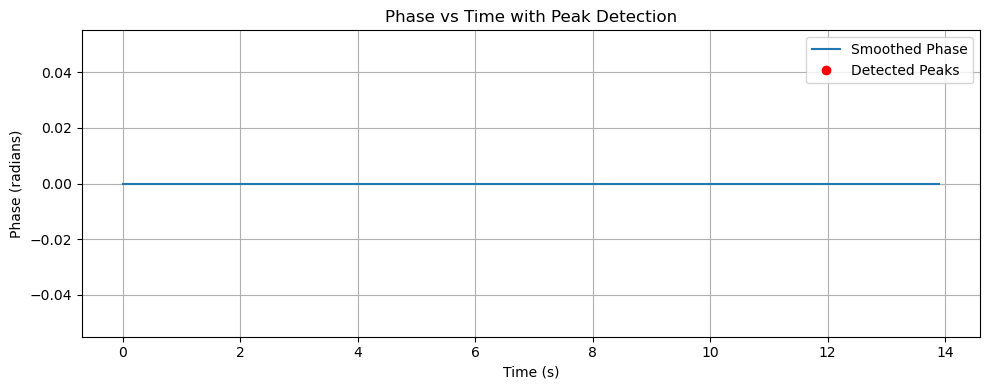

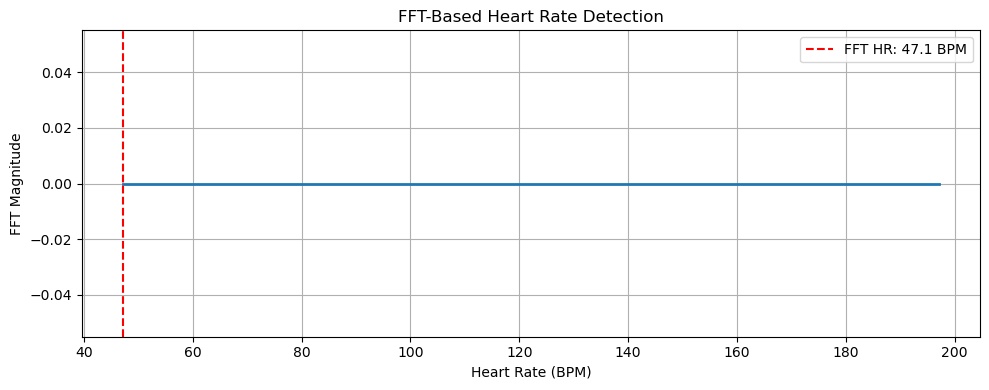

Not enough peaks for interval-based heart rate.
Heart Rate (from FFT): 47.14 BPM


In [97]:

# --- Load Data ---
with open("tx_hrbr.json", "r") as f_tx, open("rx_hrbr.json", "r") as f_rx:
    tx_data = json.load(f_tx)
    rx_data = json.load(f_rx)

tx_data = np.array(tx_data)
rx_data = np.array(rx_data)

window_length = rx_data.shape[1]
chirp_length = 0.1 

# --- Dechirp ---
dechirped = rx_data * np.conj(tx_data)

# --- FFT ---
fft_size = window_length
fft_data = np.fft.fft(dechirped, n=fft_size, axis=1)

bin_to_track = np.argmax(np.mean(np.abs(fft_data), axis=0))
phases = np.angle(fft_data[:, bin_to_track])
unwrapped_phases = np.unwrap(phases)
detrended_phase = detrend(unwrapped_phases)

# --- Time axis ---
times = np.arange(unwrapped_phases.shape[0]) * chirp_length

# --- Bandpass filter for HR range (0.67–3.33 Hz = 40–200 BPM) ---
def bandpass(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

fs = 1 / chirp_length
hr_filtered = bandpass(detrended_phase, 60 / 60, 200 / 60, fs)

# --- Smoothed for peak detection ---
# smoothed = savgol_filter(hr_filtered, window_length=11, polyorder=2)
def moving_average(x, w):
    return np.convolve(x, np.ones(w)/w, mode='same')

smoothed = moving_average(hr_filtered, w=5)

# --- Peak Detection ---
peaks, _ = find_peaks(smoothed, height=0.0001, distance=fs/8)

# --- Estimate BPM from peak intervals ---
if len(peaks) > 1:
    intervals = np.diff(times[peaks])
    avg_interval = np.mean(intervals)
    med = statistics.median(intervals)
    bpm_from_peaks = 60 / med
    # bpm_from_peaks = (60/14) * len(peaks)
else:
    bpm_from_peaks = None

# --- FFT Estimate (from your original logic) ---
hr_fft = np.fft.rfft(hr_filtered)
hr_freqs = np.fft.rfftfreq(len(hr_filtered), d=chirp_length)
hr_bpm_freqs = hr_freqs * 60
mask = (hr_bpm_freqs >= 45) & (hr_bpm_freqs <= 200)
hr_bpm_freqs = hr_bpm_freqs[mask]
hr_fft_mag = np.abs(hr_fft)[mask]

if len(hr_fft_mag) > 5:
    min_bpm = 40  # min expected heart rate
    min_idx = np.argmin(np.abs(hr_bpm_freqs - min_bpm))
    peak_idx = np.argmax(hr_fft_mag[min_idx:]) + min_idx
else:
    peak_idx = np.argmax(hr_fft_mag)

bpm_from_fft = hr_bpm_freqs[peak_idx]

# --- Plot Phase vs Time and Peaks ---
plt.figure(figsize=(10, 4))
plt.plot(times, smoothed, label='Smoothed Phase')
plt.plot(times[peaks], smoothed[peaks], 'ro', label='Detected Peaks')
plt.xlabel("Time (s)")
plt.ylabel("Phase (radians)")
plt.title("Phase vs Time with Peak Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot FFT ---
plt.figure(figsize=(10, 4))
plt.plot(hr_bpm_freqs, hr_fft_mag, linewidth=2)
plt.axvline(x=bpm_from_fft, color='r', linestyle='--', label=f'FFT HR: {bpm_from_fft:.1f} BPM')
plt.xlabel("Heart Rate (BPM)")
plt.ylabel("FFT Magnitude")
plt.title("FFT-Based Heart Rate Detection")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Print results ---
if bpm_from_peaks:
    print(f"Heart Rate (from peak intervals): {bpm_from_peaks:.2f} BPM")
else:
    print("Not enough peaks for interval-based heart rate.")

print(f"Heart Rate (from FFT): {bpm_from_fft:.2f} BPM")
